In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
plt.rcParams["figure.figsize"] = (10,6) # tüm görsellerin aynı boyutta olması için sabitledik.
import warnings
warnings.filterwarnings("ignore") # verilen uyarıları notebook getirmesin.

In [2]:
df = pd.read_csv("Advertising.csv")
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


### NaN kontrol :

In [3]:
df.info()
# NaN değerimiz yok.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


### Outlier Kontrol : 

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


TV tablosunda toplamda = 0  adet aykırı alt veri vardır.
TV tablosunda toplamda = 0 adet aykırı üst veri vardır.
radio tablosunda toplamda = 0  adet aykırı alt veri vardır.
radio tablosunda toplamda = 0 adet aykırı üst veri vardır.
newspaper tablosunda toplamda = 0  adet aykırı alt veri vardır.
newspaper tablosunda toplamda = 2 adet aykırı üst veri vardır.


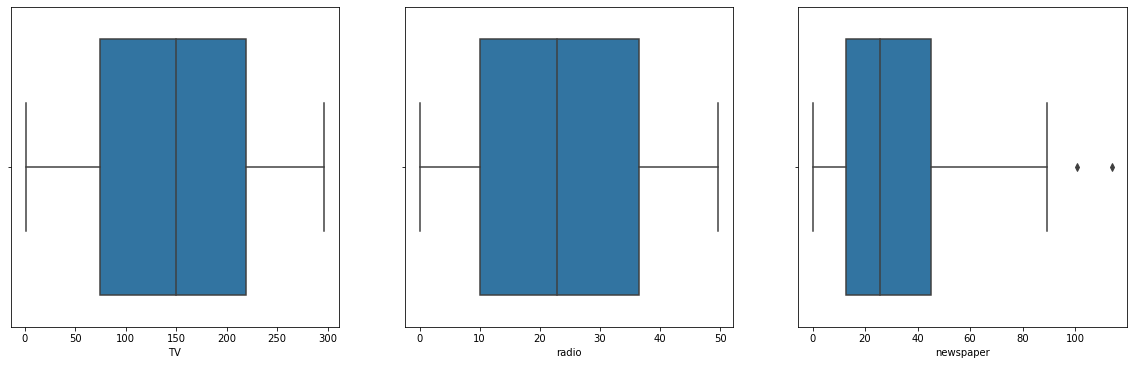

In [5]:
index = 0
plt.figure(figsize=(20,20))
for i in df.columns:
    if i != "sales":
        index += 1
        plt.subplot(3,3,index)
        sns.boxplot(df[i])
        Q1 =df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3-Q1
        alt_sinir = Q1-(1.5*IQR)
        ust_sinir = Q3+(1.5*IQR)
        #print(f"{i} sutununun alt sınır değeri = {alt_sinir}")
        #print(f"{i} sutununun üst sınır değeri = {ust_sinir}")
        aykiri_alt = df[i] < alt_sinir
        aykiri_ust = df[i] > ust_sinir
        print(i, "tablosunda toplamda =", df[i][aykiri_alt].count()," adet aykırı alt veri vardır.")
        print(i, "tablosunda toplamda =",df[i][aykiri_ust].count(), "adet aykırı üst veri vardır.")

### MultiColinearty : 

In [6]:
df.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


In [7]:
multi = df.corr()
multi[(multi != 1) & (multi > 0.7)]
# görüldüğü üzere futurelerin hiçbiri kendi aralarında yüksek korelasyonları yok. her future kendisi ile yüksek korelasyına 
# sahip. çaprazda olanlar kendi kendileri ile korelasyon değerleri. onları getirmemen için 1 e eşit olmayanlar ve 0.7 den büyük
# olanları istedik. Tv ve sales korelsayonu 0.78

,TV,radio,newspaper,sales
TV,NaN,NaN,NaN,0.782224
radio,NaN,NaN,NaN,NaN
newspaper,NaN,NaN,NaN,NaN
sales,0.782224,NaN,NaN,NaN


### Test Train Modelleme : 

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df.drop("sales", axis=1) # future
y = df["sales"] # target

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### Standart Scale : 

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

### Hata Metricleri : 

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [14]:
def train_val(y_train, y_train_pred, y_test, y_pred, i):
    
    scores = {i+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    i+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)
# bu skorları görmek için yazılmış bir fonksiyondur.

### Default ile Linear regression modelleme : 

In [15]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaler, y_train)
y_pred = model.predict(X_test_scaler)
y_train_pred = model.predict(X_train_scaler)
ls = train_val(y_train, y_train_pred, y_test, y_pred, "linear")
ls
# skorlar arasında Overfiting yok. train ve test arasında skorlar çok dengeli.

,linear_train,linear_test
R2,0.896645,0.893516
mae,1.215619,1.402312
mse,2.767891,2.880024
rmse,1.663698,1.697063


### Cross Validate : 

In [16]:
from sklearn.model_selection import cross_validate
# cross_validate ile tüm skorları kontrol edebiliriz. cross validate ile tüm train datamızda ki değerler teker teker fit edilir
# ve her satır için 1 değeri test için ayırır. sonra cv değeri kadar tüm datanın skorlarını alır. skorların ortalamasını alır
# bize ortalama skorları verir.

In [17]:
model = LinearRegression() # linear regresyon tanımladık.
scores = cross_validate(model, X_train_scaler, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)
# tüm modeli içerisine yazabiliriz. sırasıyla bu şekilde yazılır. scoresun içinde işimize yarayacak skorları düzenleriz.
# r2 skorda - olması kafa karıştırması pozitif olarak değerlendireceğiz. datayı 10 e bölmek istedik.
# her data da cross validation yapılması gerekmektedir. 
# cv ne kadar büyük olursa o kadar güvenli skorlar verilir. 
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()
# cross validate ile de skorların oldukça yakın olduğu görüldü. ve overfiting durumu yok.

test_r2                             0.860913
test_neg_mean_absolute_error       -1.262778
test_neg_mean_squared_error        -3.024495
test_neg_root_mean_squared_error   -1.656295
dtype: float64

### Ridge model ile skoru almak : 

In [18]:
from sklearn.linear_model import Ridge

In [19]:
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train_scaler, y_train)
y_pred = ridge_model.predict(X_test_scaler)
y_train_pred = ridge_model.predict(X_train_scaler)
ridge_score = train_val(y_train, y_train_pred, y_test, y_pred, "ridge")
ridge_score

,ridge_train,ridge_test
R2,0.896606,0.893535
mae,1.216458,1.400372
mse,2.768911,2.879523
rmse,1.664004,1.696916


In [20]:
# Ridge skorları cross validate ile kontrol ettik.
model = Ridge()
scores = cross_validate(model, X_train_scaler, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()


test_r2                             0.861369
test_neg_mean_absolute_error       -1.264688
test_neg_mean_squared_error        -3.026084
test_neg_root_mean_squared_error   -1.656817
dtype: float64

In [21]:
pd.concat([ls, ridge_score], axis=1)
# skorlar aynı.

,linear_train,linear_test,ridge_train,ridge_test
R2,0.896645,0.893516,0.896606,0.893535
mae,1.215619,1.402312,1.216458,1.400372
mse,2.767891,2.880024,2.768911,2.879523
rmse,1.663698,1.697063,1.664004,1.696916


### RidgeCV ile skorlara bakalım : 

In [22]:
from sklearn.linear_model import RidgeCV

In [23]:
alpa_space = np.linspace(0.01,10,1000)
alpa_space

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
        0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
        0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,
        0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,  0.63,
        0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,
        0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,  0.81,
        0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,  0.9 ,
        0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99,
        1.  ,  1.01,  1.02,  1.03,  1.04,  1.05,  1.06,  1.07,  1.08,
        1.09,  1.1 ,  1.11,  1.12,  1.13,  1.14,  1.15,  1.16,  1.17,
        1.18,  1.19,  1.2 ,  1.21,  1.22,  1.23,  1.24,  1.25,  1.26,
        1.27,  1.28,

In [24]:
ridge_cv_model = RidgeCV(alphas= alpa_space, scoring="r2", cv=5)
ridge_cv_model.fit(X_train_scaler, y_train)
y_pred = ridge_cv_model.predict(X_test_scaler)
y_train_pred = ridge_cv_model.predict(X_train_scaler)
ridge_score_cv = train_val(y_train, y_train_pred, y_test, y_pred, "ridge_cv")
ridge_score_cv

,ridge_cv_train,ridge_cv_test
R2,0.896636,0.893535
mae,1.216016,1.401402
mse,2.768118,2.879523
rmse,1.663766,1.696916


In [26]:
ridge_cv_model.alpha_
# en iyi alpha değeri alpha değeri bizim train ve test arasında ki farkı gidermek için eklenen bias değeridir.

0.47000000000000003

### Lasso Default : 

In [27]:
from sklearn.linear_model import Lasso, LassoCV

In [28]:
lasso_model = Lasso(random_state=42)
lasso_model.fit(X_train_scaler, y_train)
y_pred = lasso_model.predict(X_test_scaler)
y_train_pred = lasso_model.predict(X_train_scaler)
lasso_score = train_val(y_train, y_train_pred, y_test, y_pred, "lasso")
lasso_score
# skorlarımız düştü.

,lasso_train,lasso_test
R2,0.824970,0.831350
mae,1.576285,1.546627
mse,4.687354,4.561408
rmse,2.165030,2.135745


In [29]:
# Lasso skorları cross validate ile kontrol ettik.
model = Lasso()
scores = cross_validate(model, X_train_scaler, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()


test_r2                             0.790370
test_neg_mean_absolute_error       -1.634312
test_neg_mean_squared_error        -5.074699
test_neg_root_mean_squared_error   -2.159019
dtype: float64

In [33]:
lasso_cv_model = LassoCV(alphas = alpa_space, cv = 5, max_iter=100000, random_state=42)
lasso_cv_model.fit(X_train_scaler, y_train)
y_pred = lasso_cv_model.predict(X_test_scaler)
y_train_pred = lasso_cv_model.predict(X_train_scaler)
lasso_score_cv = train_val(y_train, y_train_pred, y_test, y_pred, "lasso_cv")
lasso_score_cv
# skorlarda biraz düzelme oldu.

,lasso_cv_train,lasso_cv_test
R2,0.896097,0.895089
mae,1.217979,1.377568
mse,2.782565,2.837496
rmse,1.668102,1.684487


In [34]:
lasso_cv_model.alpha_
# lasso için en iyi alpa değeri.

0.08

In [36]:
pd.concat([ls, ridge_score, ridge_score_cv, lasso_score, lasso_score_cv], axis=1)
# en yüksek skorumuz lassocv ile test için.

,linear_train,linear_test,ridge_train,ridge_test,ridge_cv_train,ridge_cv_test,lasso_train,lasso_test,lasso_cv_train,lasso_cv_test
R2,0.896645,0.893516,0.896606,0.893535,0.896636,0.893535,0.824970,0.831350,0.896097,0.895089
mae,1.215619,1.402312,1.216458,1.400372,1.216016,1.401402,1.576285,1.546627,1.217979,1.377568
mse,2.767891,2.880024,2.768911,2.879523,2.768118,2.879523,4.687354,4.561408,2.782565,2.837496
rmse,1.663698,1.697063,1.664004,1.696916,1.663766,1.696916,2.165030,2.135745,1.668102,1.684487


### ElasticNet ile yapalım : 

In [37]:
from sklearn.linear_model import ElasticNet

In [38]:
elastic_model = ElasticNet()
elastic_model.fit(X_train_scaler, y_train)
y_pred = elastic_model.predict(X_test_scaler)
y_train_pred = elastic_model.predict(X_train_scaler)
elastic_score = train_val(y_train, y_train_pred, y_test, y_pred, "elasticnet")
elastic_score
# skorlar düştü.

,elasticnet_train,elasticnet_test
R2,0.739561,0.739295
mae,2.008567,2.122104
mse,6.974628,7.051194
rmse,2.640952,2.655408


### GridSearch İle en iyi elastic model parametresi bulalım : 

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {"alpha":[0.01, 0.012, 0.2, 0.5, 0.6, 0.7, 1],
            "l1_ratio":[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}

model = ElasticNet(max_iter=10000, random_state=42)

grid_model = GridSearchCV(estimator = elastic_model, param_grid = param_grid, scoring = 'neg_root_mean_squared_error',
                         cv =5)

grid_model.fit(X_train_scaler, y_train)


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.012, 0.2, 0.5, 0.6, 0.7, 1],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_root_mean_squared_error')

In [41]:
grid_model.best_params_

{'alpha': 0.012, 'l1_ratio': 1}

In [44]:
y_pred = grid_model.predict(X_test_scaler)
y_train_pred = grid_model.predict(X_train_scaler)
el_cv = train_val(y_train, y_train_pred, y_test, y_pred, "grid_elactic_cv")
el_cv

,grid_elactic_cv_train,grid_elactic_cv_test
R2,0.896632,0.893851
mae,1.215426,1.397774
mse,2.768231,2.870977
rmse,1.663800,1.694396


In [47]:
pd.concat([ls, ridge_score, ridge_score_cv, lasso_score, lasso_score_cv, el_cv], axis=1).T

,R2,mae,mse,rmse
linear_train,0.896645,1.215619,2.767891,1.663698
linear_test,0.893516,1.402312,2.880024,1.697063
ridge_train,0.896606,1.216458,2.768911,1.664004
ridge_test,0.893535,1.400372,2.879523,1.696916
ridge_cv_train,0.896636,1.216016,2.768118,1.663766
ridge_cv_test,0.893535,1.401402,2.879523,1.696916
lasso_train,0.824970,1.576285,4.687354,2.165030
lasso_test,0.831350,1.546627,4.561408,2.135745
lasso_cv_train,0.896097,1.217979,2.782565,1.668102
lasso_cv_test,0.895089,1.377568,2.837496,1.684487


### Final Model : 

In [48]:
lasso_cv_model.alpha_

0.08

In [49]:
final_model = Lasso(alpha = 0.08, max_iter=10000, random_state=42)
final_model.fit(X_train_scaler, y_train)
y_pred = final_model.predict(X_test_scaler)
y_train_pred = final_model.predict(X_train_scaler)
final_score = train_val(y_train, y_train_pred, y_test, y_pred, "lasso")
final_score

,lasso_train,lasso_test
R2,0.896097,0.895089
mae,1.217979,1.377568
mse,2.782565,2.837496
rmse,1.668102,1.684487


### İstenirse Ridge, lasso veya Elastic için Grid SearchtCV direk en iyi değeri seçeriz : 

Ama geliştiriciler RidgeCV ve LassoCV ile bu işlemi direk yapmışlar.

In [50]:
param_grid = {"alpha": alpa_space}

model = Lasso(max_iter=10000, random_state=42)

grid_model_lasso = GridSearchCV(estimator = elastic_model, param_grid = param_grid, scoring = 'neg_root_mean_squared_error',
                         cv = 10)

grid_model_lasso.fit(X_train_scaler, y_train)


GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
        0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
        0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,
        0.55,  0.56,  0.57,  0...
        9.37,  9.38,  9.39,  9.4 ,  9.41,  9.42,  9.43,  9.44,  9.45,
        9.46,  9.47,  9.48,  9.49,  9.5 ,  9.51,  9.52,  9.53,  9.54,
        9.55,  9.56,  9.57,  9.58,  9.59,  9.6 ,  9.61,  9.62,  9.63,
        9.64,  9.65,  9.66,  9.67,  9.68,  9.69,  9.7 ,  9.71,  9.72,
        9.73,  9.74,  9.75,  9.76,  9.77,  9.78,  9.79,  9.8 ,  9.81,
        9.82,  9.83,  9.84,  9.85,  9.86,  9.87,  9.88,  9.89,  9.9 ,
        9.91,  9.92,  9.93,  9.94,  9.95,  9.96,

In [51]:
grid_model_lasso.best_params_

{'alpha': 0.01}

In [52]:
y_pred = grid_model_lasso.predict(X_test_scaler)
y_train_pred = grid_model_lasso.predict(X_train_scaler)
grid_score = train_val(y_train, y_train_pred, y_test, y_pred, "grid_ls")
grid_score

,grid_ls_train,grid_ls_test
R2,0.896610,0.893669
mae,1.216171,1.398973
mse,2.768805,2.875903
rmse,1.663973,1.695849


In [56]:
pd.concat([final_score, grid_score], axis=1)
# lasso cv ile grid searc ile bulduğum skordan biraz daha iyi buldu.

,lasso_train,lasso_test,grid_ls_train,grid_ls_test
R2,0.896097,0.895089,0.896610,0.893669
mae,1.217979,1.377568,1.216171,1.398973
mse,2.782565,2.837496,2.768805,2.875903
rmse,1.668102,1.684487,1.663973,1.695849
